<a href="https://colab.research.google.com/github/sokanaid/CourseProject2022BiologicalMath/blob/main/find_plateau_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подбор порога остановы на плато

In [52]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [24]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/sim_tables

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/sim_tables


## Чтение данных

In [25]:
def read_csv_file(directory_path, name):
  file_path = os.path.join(directory_path, name + ".csv")
  # print("read file ", file_path)
  return pd.read_csv(file_path)

In [26]:
def read_description(directory_path, file_name = "description.txt", parse_params = False):
  file_path = os.path.join(directory_path, file_name)
  # print("read description from file  ", file_path)
  with open(file_path, 'r') as file:
    if not parse_params:
      return file.read()
    result = {}
    for line in file:
      name, value = line.split('=')
      value = value.strip(' \t\n\r')
      if value == 'TRUE':
        value = True
      elif value == 'FALSE':
        value = False
      else:
        try:
          value = float(value)
        except:
          try:
            value = int(value)
          except:
            ...
      result[name] = value
    return result

In [27]:
def read_files(directory_path):
  data = {}
  # строковое описание параметров
  data["description_str"] = read_description(directory_path)
  # описание параметров в виде словаря
  data["params"] =  read_description(directory_path, parse_params = True)
  # численность популяции
  data["population"] = read_csv_file(directory_path, "population")
  data["population"].drop(data["population"].tail(1).index, inplace=True)
  data["population"].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  # результаты последовательных сглаживаний численности популяции
  name = "exp_pop10"
  data[name] = read_csv_file(directory_path, name)
  data[name].rename(columns={"Unnamed: 0": 'epochs'}, inplace=True)
  return data

In [28]:
# читаем все результаты симуляций из папок
def read_all_simulations(directories_paths):
  data = []
  for directory_path in directories_paths:
    for simulation_diractory_name in os.listdir(directory_path):
      simulation_diractory_path = os.path.join(directory_path, simulation_diractory_name)
      if os.path.isdir(simulation_diractory_path):
        data.append(read_files(simulation_diractory_path))
  return data

## Построение графиков

In [43]:
def print_all_in_one_frame(data, x="time", y = "population", limit = 25000):
  if y== "exp_pop":
    type_d = "exp_pop"
  if 'exp' in y and y!="exp_pop":
    type_d = "exp_pop2"
  else:
    type_d = "pop"
  fig = plt.figure(figsize=(40, 5), dpi=80)
  plt.axis('off')
  plt.title("Simulations" )
  #fig.tight_layout(pad=6.0,  h_pad=3, w_pad=3)
  fig.patch.set_visible(False)
  axes = fig.subplots(nrows=1, ncols=1)
  for data_ in data:
    axes.plot(data_[y][x][:limit], data_[y][type_d][:limit])
    axes.set_xlabel(x)
    axes.set_ylabel(type_d)

## Работа с симуляциями


In [63]:
directories = ["/content/drive/MyDrive/sim_tables/find_plateau_threshold_ks3"]
data = read_all_simulations(directories)

In [31]:
data[0]['params']

{'dd': 0.75,
 'death_r': 600.0,
 'epochs_count': 25000.0,
 'plateau_threshold': 8.0,
 'area_length_x': 6000.0,
 'initial_pop': 100.0,
 'auto_stop_at_plateau': False,
 'b': 100.0,
 'd': 0.0,
 'sd_b': 0.7,
 'sd_d': 0.6,
 'found_plateau': False,
 'realtime_limit_reached': False}

In [32]:
data[2]["population"].tail(100000)

,epochs,time,pop
0,1,0.000000,100
1,2,0.007568,196
2,3,0.014808,382
3,4,0.021161,710
4,5,0.027627,1214
...,...,...,...
24995,24996,124.977110,6588
24996,24997,124.982167,6526
24997,24998,124.987067,6664
24998,24999,124.992197,6688


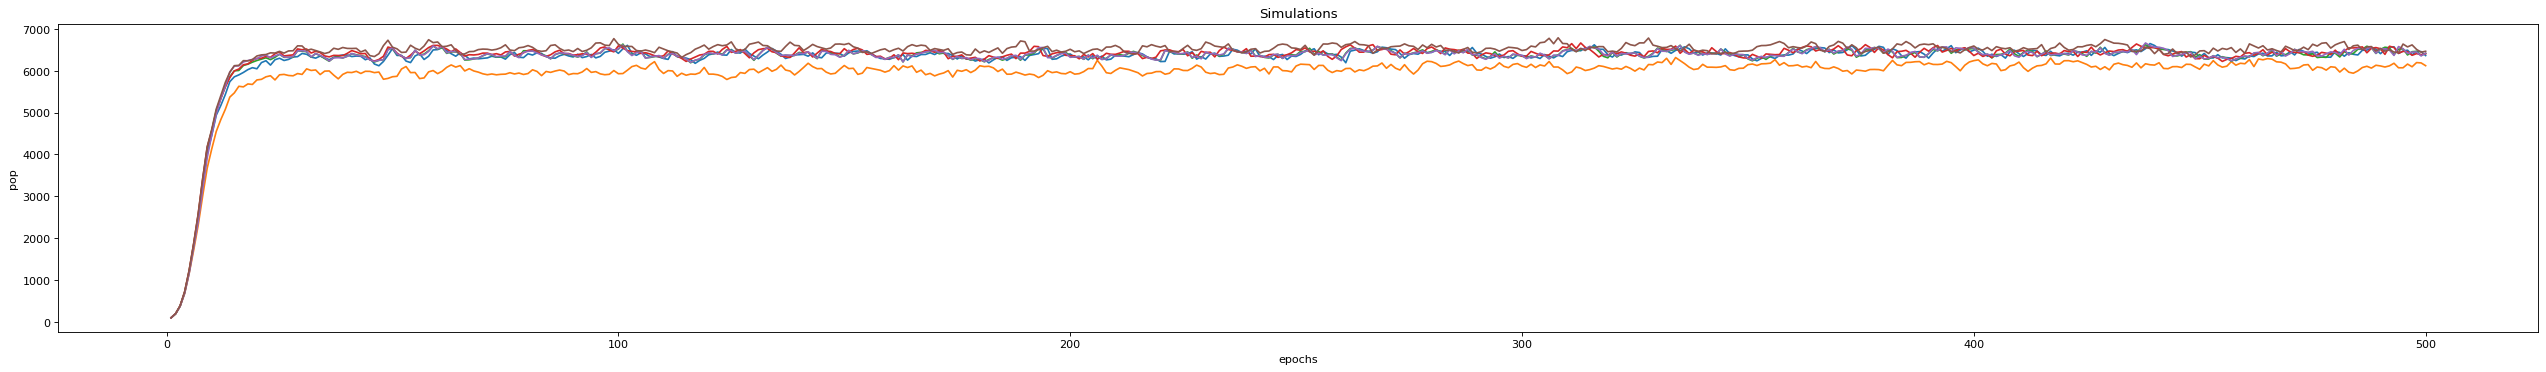

In [51]:
# построим все графики 
print_all_in_one_frame([data_ for data_ in data if not data_["params"]['auto_stop_at_plateau'] and not data_["params"]['realtime_limit_reached']] ,x = "epochs", limit = 500)

In [37]:
data[0]["exp_pop10"]

,epochs,time,exp_pop2
0,1,0.000000,100.000000
1,2,0.008018,106.000000
2,3,0.014887,126.375000
3,4,0.021797,173.187500
4,5,0.028320,262.570312
...,...,...,...
24996,24997,124.984617,6577.903754
24997,24998,124.989536,6580.144942
24998,24999,124.994518,6586.646551
24999,25000,124.999482,6594.013296


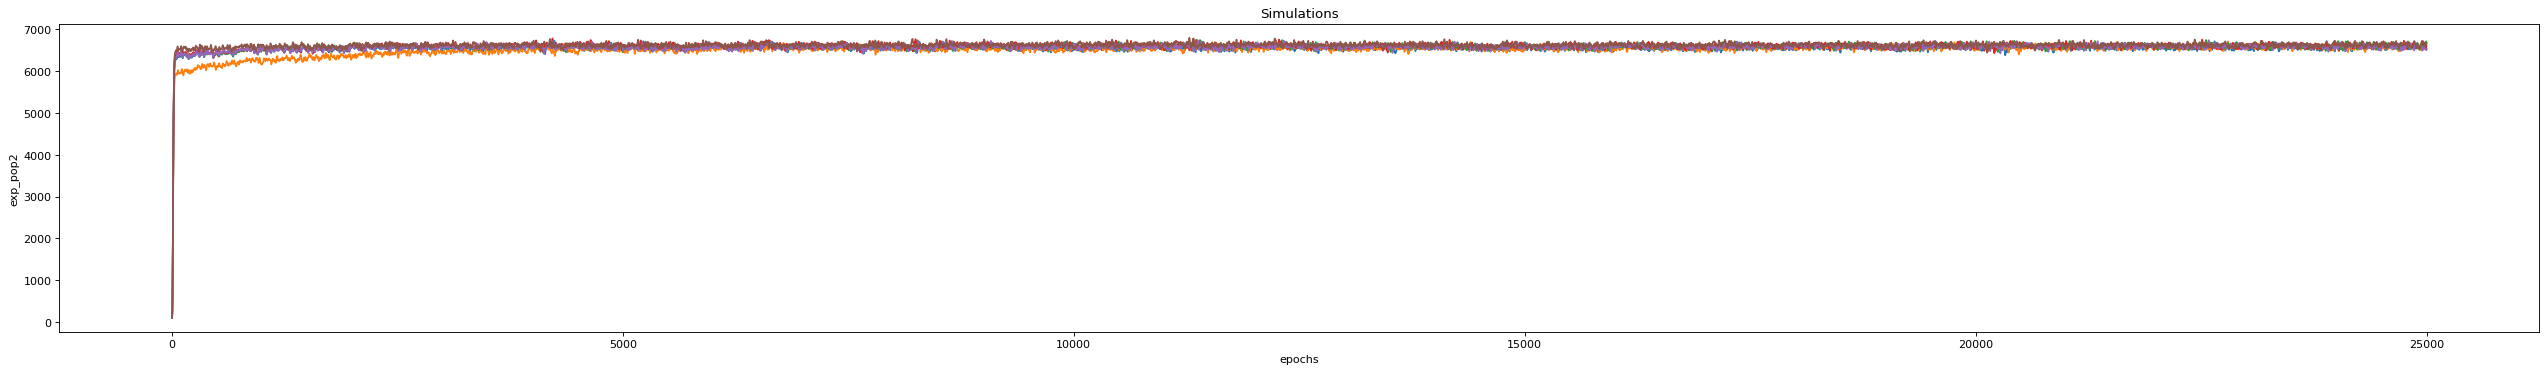

In [46]:
# построим все графики после 10 экспоненциального сглаживания
print_all_in_one_frame([data_ for data_ in data if not data_["params"]['auto_stop_at_plateau'] and not data_["params"]['realtime_limit_reached']] ,x = "epochs", y = "exp_pop10")

## Подбор окна сглаживания

(array([3., 0., 0., 0., 4., 0., 0., 0., 0., 4., 0., 0., 0., 0., 4., 0., 0.,
        0., 4.]),
 array([1.        , 1.21052632, 1.42105263, 1.63157895, 1.84210526,
        2.05263158, 2.26315789, 2.47368421, 2.68421053, 2.89473684,
        3.10526316, 3.31578947, 3.52631579, 3.73684211, 3.94736842,
        4.15789474, 4.36842105, 4.57894737, 4.78947368, 5.        ]),
 <BarContainer object of 19 artists>)

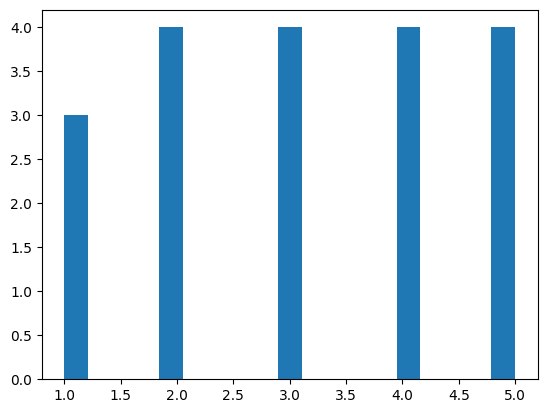

In [66]:
datax = [1, 2, 3, 4, 5, 5, 4, 3, 2, 1, 2, 3, 4, 5, 5, 4, 3, 2, 1]

# Строим гистограмму на основе массива данных
plt.hist(datax, bins=len(datax))

[3353736.113421053, 1565.8998747109708, 1778.5040431447549, 2060.4533396700836, 1981.867922491385, 1437.3646128206092, 1673.6658943283076, 1231.7167605218506, 960.7103301946904, 2275.8958142117717, 1379.6050930296572, 858.1200655666288, 1382.0073033593844, 1750.7285978481655, 1904.5844634148007, 1506.2115084931054, 1711.0967997202415, 881.0539084598312, 739.0687774945177, 1830.5306342550807, 1348.1583857003507, 2382.1518303391967, 899.7471000160293, 750.3475067886524, 2662.4773013267836, 1259.5008298398936, 667.7771676003666, 2514.3647910936306, 1519.3624784066944, 1190.3045043756968, 543.4763021955524, 1344.7264543269898, 1655.3018084578196, 2126.3477714742353, 1440.1426501673493, 1436.3315465717603, 821.3507228014097, 1128.521279211046, 1103.9020172619114, 1279.496178358119, 1419.6362139824769, 3065.773446234134, 2755.96848424092, 1392.2839989782024, 527.2803232377101, 1630.6482739104622, 2574.1922855671505, 596.8806121260809, 2171.9236822767984, 1750.488169182304, 1196.6808576322796

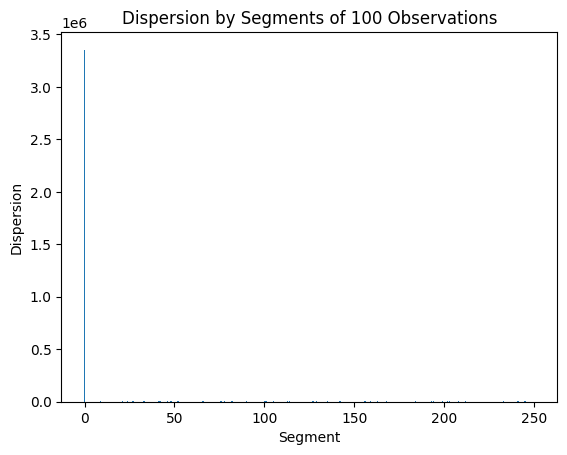

[1310034.1102313101, 1836.9601473143189, 2519.5653570304603, 1583.003082897373, 1873.3278841050897, 1645.5453316143755, 1786.6932547815939, 1366.0003916049307, 1647.9036915471258, 1779.4597588867528, 1196.7721271835112, 1716.006327501407, 1027.3846036086775, 2112.6890046823705, 2124.184336265293, 1623.020643082298, 1788.1059331015404, 1917.230059507261, 1745.8474616241158, 1585.1055759030808, 1435.5804569310837, 1657.7012581507838, 2580.3706592908384, 1220.0750675181866, 1349.698117476232, 1761.4539101791127, 1902.6734957196013, 2311.823228006524, 1893.4583331425108, 892.3229302471701, 1233.6618456674482, 1410.9435442015222, 1487.1490861214027, 2442.0916317466163, 1253.9883199940475, 1975.0845628494367, 1263.4640776202045, 1703.0244771433122, 2030.2005105394692, 1741.7202515189738, 1074.139975109906, 1818.5542163868333, 1646.1008365498608, 1530.184613870145, 1009.8398634475735, 1771.6839426967315, 1349.1295191098598, 1520.642980503411, 1358.4671425446115, 1451.704702631879, 1212.167947

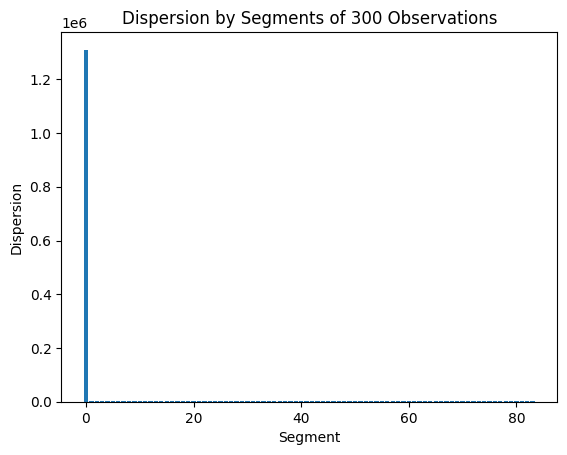

[816626.3173571454, 2837.290709379312, 1592.3768659799798, 1502.163632141792, 1666.6962489843909, 1507.3025291020385, 1479.136627461503, 1268.3988877629215, 2272.544463929359, 1780.2371157548046, 1904.7587853998104, 1638.393447794368, 1461.5141332627081, 2263.883148794713, 1215.0526661800272, 2100.5048363706883, 1930.3826079659714, 1312.7666999635765, 1532.784546802137, 1339.898133427087, 1900.6117631754648, 1611.0460044199851, 2223.886871796404, 1624.9322489929925, 1453.8995462337452, 1662.527434488888, 1085.9801541250977, 1636.1241357386646, 1414.254210859089, 1590.0993682930548, 1200.3289270921382, 1971.3688372371103, 1625.6728554243762, 1473.812062376904, 1962.9531377639719, 1298.9632360733124, 1327.1410793126718, 1463.8232997474931, 1890.7876554541322, 1683.2928879988124, 2244.936450439117, 1315.927399066421, 1899.4257169584814, 1226.2251860367662, 981.639563923002, 1782.0571405697533, 2026.2009803338321, 1390.9602068097518, 1699.9547434879162, 1627.6207795895364, 0.0]
51


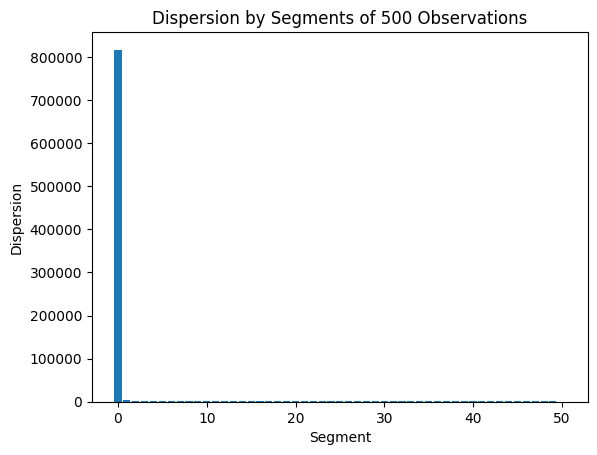

[427359.44226050086, 1549.8474946749461, 1653.2713207860756, 1407.2083842494737, 2031.0030302106672, 1772.1503500369797, 1896.5253179100337, 1828.0924149130908, 1691.3255955396444, 1516.4466509402573, 1757.6366369735435, 2039.0091258583798, 1655.5378529072916, 1398.7236237295015, 1587.4697299103227, 1585.8506304995217, 1682.2226032140475, 1631.182517177449, 1395.4827661933978, 2075.2405327649653, 1789.2072384828382, 1588.063367351607, 1433.4065504517305, 1708.8309453153308, 1674.8916468055393, 0.0]
26


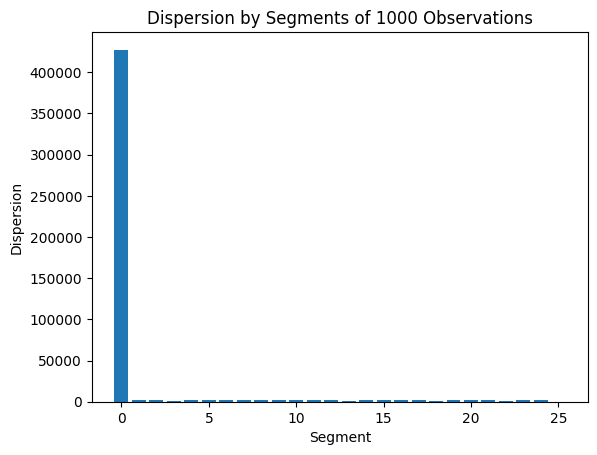

In [74]:
for size in [100, 300, 500, 1000]:
  data_ = data[0]["exp_pop10"]["exp_pop2"]
  data_segments = [data_[i:i+size] for i in range(0, len(data_), size)]
  #print(data_segments)
  variances = [np.var(segment) for segment in data_segments]
  print(variances)
  print(len(variances))
  plt.bar(range(0, len(variances)), variances)#, bins = len(variances))
  # Добавляем заголовок и метки осей
  plt.title('Dispersion by Segments of ' + str(size) + ' Observations')
  plt.xlabel('Segment')
  plt.ylabel('Dispersion')
  plt.show()
